In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import tqdm
import energyflow as ef
import numpy as np
from IPython.display import Image

# setup matplotlib
plt.rc("font", family="serif", size=16)
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)
plt.rc("linewidth=2")

# fontsize
FONTSIZE = 14
FONTSIZE_LEGEND = 10
TICKLABELSIZE = 8
MC_RECO_COLOR = "C0"
MC_HARD_COLOR = "black"
MC_UNFOLD_COLOR = "C1"
DATA_RECO_COLOR = "C2"
DATA_HARD_COLOR = "C3"
DATA_UNFOLD_COLOR = "#1a53ff"


# Iterative Unfolding à la Generative

## The iterative method

![ICFM Plot](iterative_setup.png)

Image adapted from M. Backes, A. Butter, M. Dunford, and B. Malaescu, An unfolding method based on conditional Invertible Neural Networks (cINN) using iterative training, [arXiv:2212.08674](https://arxiv.org/abs/2212.08674).

The idea is to update iteratively the prior with which your unfolding algorithm is trained.


* Step 1: Train CFM with MC Truth and MC Reco until convergence

* Step 2: Predict MC Unfolded (closure check) and your Data Unfolded

* Step 3: Train a binary classifier between MC Truth (class 0) and Data Unfolded (class 1). Reweight MC Truth to match your Data Unfolded.

* Step 4: Repeat from Step 1 using reweighted Data Unfolded as new prior.

## Conditional Flow Matching

![CFM Scheme](CFM.png)

### Model architecture

In [8]:
class Iterative_CFM(nn.Module):
    def __init__(self,
                 dims_truth,            # number of truth features
                 dims_reco,             # number of reco features
                 cfm_params,            # parameters dict for the CFM
                 classifier_params,     # parameters dict for the classifier
                 MC_reco,               # MC reco events
                 MC_truth,              # MC truth events
                 data_reco,             # Data reco events
                 data_truth,            # Data truth events
                 bins,                  # bins for each observable for plotting
                 mu_unf=None,           # initial mu of the prior (for toy data)
                 sigma_unf=None,        # initial sigma of the prior (for toy data)
                 data_truth_mu=None,    # mean of the data truth (for toy data)
                 mu_smear=None,         # mean of the smearing (for toy data)
                 sigma_smear=None       # sigma of the smearing (for toy data)
                ):
        super().__init__()
        self.dims_truth = dims_truth
        self.dims_reco = dims_reco
        t_dim = 1
        self.input_dim = dims_truth + dims_reco + t_dim
        self.output_dim = dims_truth
        self.cfm_params = cfm_params
        self.classifier_params = classifier_params        

        
        # keep a copy of means of std for normalization
        self.MC_reco_mean = MC_reco.mean(axis=0)
        self.MC_reco_std = MC_reco.std(axis=0)
        self.MC_truth_mean = MC_truth.mean(axis=0)
        self.MC_truth_std = MC_truth.std(axis=0)

        # Normalize input
        self.MC_truth = self.normalize_input(MC_truth, self.MC_truth_mean, self.MC_truth_std)
        self.MC_reco = self.normalize_input(MC_reco, self.MC_reco_mean, self.MC_reco_std)
        self.data_truth = self.normalize_input(data_truth, self.MC_truth_mean, self.MC_truth_std)
        self.data_reco = self.normalize_input(data_reco, self.MC_reco_mean, self.MC_reco_std)

        self.bins = bins
        self.mu_unf = mu_unf
        self.sigma_unf = sigma_unf
        self.mu_prior = mu_unf
        self.sigma_prior = sigma_unf
        self.data_truth_mu = data_truth_mu
        self.mu_smear = mu_smear
        self.sigma_smear = sigma_smear
        self.build_distributions()
        

    def init_networks(self):
        '''
        Initialize the CFM and the classifier networks
        '''
        layers = []
        layers.append(nn.Linear(self.input_dim, self.cfm_params["layers_width"])) # initial layer takes as input the reco and truth features and the time t
        layers.append(nn.ReLU())
        for _ in range(self.cfm_params["n_hidden_layers"]):
            layers.append(nn.Linear(self.cfm_params["layers_width"], self.cfm_params["layers_width"]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.cfm_params["layers_width"], self.output_dim))
        self.net = nn.Sequential(*layers)
        
        layers = []
        layers.append(nn.Linear(self.dims_truth, self.classifier_params["layers_width"]))
        layers.append(nn.ReLU())
        for _ in range(self.classifier_params["n_hidden_layers"]):
            layers.append(nn.Linear(self.classifier_params["layers_width"], self.classifier_params["layers_width"]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.classifier_params["layers_width"], 1))
        self.classifier = nn.Sequential(*layers)


    def build_distributions(self):
        '''
        Builds the time distribution and the latent space distribution
        '''
        self.t_dist = torch.distributions.uniform.Uniform(low = 0., high=1.)

        self.latent_space = self.cfm_params.get("latent_space", "gaussian")
        if self.latent_space == "gaussian":
            self.latent_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                loc=torch.zeros(self.dims_truth), covariance_matrix=torch.eye(self.dims_truth)
            )
        elif self.latent_space == "uniform":
            self.latent_dist = torch.distributions.uniform.Uniform(
                torch.full((self.dims_truth,), 0.), torch.full((self.dims_truth,), 1.)
            )
        else:
            pass
    
    
    def normalize_input(self, x, mean, std, rev=False):
        '''
        (De)normalizes the input x with mean and std
        '''
        x_c = x.clone()
        for i in range(x.shape[1]):
            if not rev:
                x_c[:, i] = (x[:, i] - mean[i]) / std[i]
            else:
                x_c[:, i] = x[:, i] * std[i] + mean[i]
        return x_c    
    
    
    def train_cfm(self, loader):
        '''
        Trains the CFM network
        '''
        n_epochs = self.cfm_params["n_epochs"]
        lr = self.cfm_params["lr"]
        optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(loader)*n_epochs)

        print(f"Training CFM for {n_epochs} epochs with learning rate: {lr}")
        for epoch in range(n_epochs):
            losses = []
            for i, batch in enumerate(loader):
                optimizer.zero_grad()
                x_truth, x_reco, weight = batch
                loss = self.batch_loss_cfm(x_truth, x_reco, weight)
                loss.backward()
                optimizer.step()
                scheduler.step()
                losses.append(loss.item())
            if epoch % 10 == 0:
                print(f"Finished epoch {epoch} with average loss {(np.array(losses).mean()):5f}")
    
    
    def batch_loss_cfm(self, x_1, c, w):
        '''
        Computes the loss for the CFM
        '''
        device=c.device
        dtype=c.dtype
        x_0 = self.latent_dist.sample((x_1.size(0), )).to(device=device, dtype=dtype)
        t = self.t_dist.sample((x_1.size(0), 1))
        x_t = (1-t) * x_0 + t * x_1
        x_t_dot = x_1 - x_0
        v_pred = self.net(torch.cat([t, x_t, c], dim=-1))
        cfm_loss = ((v_pred - x_t_dot)**2 * w).mean()
        return cfm_loss
    
    
    def evaluate_cfm(self, bs_sample):
        '''
        Samples and saves the CFM predictions for MC and Data sets
        '''
        MC_samples = []
        data_samples = []
        with torch.no_grad():
            for batch in tqdm.tqdm(torch.split(self.MC_reco, bs_sample)):
                unfold_cfm = self.sample_cfm(batch).squeeze().detach()
                MC_samples.append(unfold_cfm)
            for batch in tqdm.tqdm(torch.split(self.data_reco, bs_sample)):
                unfold_cfm = self.sample_cfm(batch).squeeze().detach()
                data_samples.append(unfold_cfm)
        MC_samples = torch.cat(MC_samples)
        data_samples = torch.cat(data_samples)
        self.MC_samples = MC_samples.unsqueeze(-1)
        self.data_samples = data_samples.unsqueeze(-1)
    

    def sample_cfm(self, c):
        '''
        Samples the CFM for a given c. Solves the ODE for t=1
        '''
        batch_size = c.size(0)  
        dtype = c.dtype
        device = c.device
        def net_wrapper(t, x_t):
            t = t * torch.ones_like(x_t[:, [0]], dtype=dtype, device=device)
            v = self.net(torch.cat([t, x_t, c], dim=-1))
            return v
        x_0 = self.latent_dist.sample((batch_size, )).to(device, dtype=dtype)
        x_t = odeint(func=net_wrapper, y0 = x_0, t=torch.tensor([0., 1.]))
        return x_t[-1]
    

    def get_true_posterior(self):
        '''
        Computes the analytical posterior (only available for toy data)
        '''
        mu_unf = self.mu_unf
        sigma_unf = self.sigma_unf
        for iter in range(self.iteration+1):
            self.mu_prior = mu_unf
            self.sigma_prior = sigma_unf
            mu_unf = ( self.data_truth_mu * sigma_unf ** 2 + mu_unf*self.sigma_smear**2 ) / (sigma_unf**2 + self.sigma_smear**2)
            sigma_unf = sigma_unf * np.sqrt(sigma_unf**2 * (sigma_unf**2 + self.sigma_smear**2) + sigma_unf**2 * self.sigma_smear**2 + self.sigma_smear ** 4) / (sigma_unf**2 + self.sigma_smear**2)
        return np.random.normal(loc=mu_unf, scale=sigma_unf, size=int((len(self.MC_samples) * 5),))


    def get_true_posterior_single(self, event_idx):
        '''
        Computes the analytical posterior for a single event given an observed reco event (only available for toy data)
        '''
        mu_single = (self.sigma_smear ** 2 * self.mu_prior - self.sigma_prior ** 2 * (self.mu_smear - (self.data_reco[event_idx] * self.MC_reco_std + self.MC_reco_mean).numpy())) / (self.sigma_smear ** 2 + self.sigma_prior ** 2)
        sigma_single2 = self.sigma_prior ** 2 * self.sigma_smear ** 2 / (self.sigma_smear ** 2 + self.sigma_prior ** 2)
        return mu_single, sigma_single2


    def plot_cfm(self, MC_samples_norm, data_samples_norm):
        '''
        Plots the results of the CFM
        '''
        # Denormalize the data
        MC_truth = self.normalize_input(self.MC_truth, self.MC_truth_mean, self.MC_truth_std, rev=True)
        data_truth = self.normalize_input(self.data_truth, self.MC_truth_mean, self.MC_truth_std, rev=True)
        MC_samples = self.normalize_input(MC_samples_norm, self.MC_truth_mean, self.MC_truth_std, rev=True)
        data_samples = self.normalize_input(data_samples_norm, self.MC_truth_mean, self.MC_truth_std, rev=True)
        MC_reco = self.normalize_input(self.MC_reco, self.MC_reco_mean, self.MC_reco_std, rev=True)
        data_reco = self.normalize_input(self.data_reco, self.MC_reco_mean, self.MC_reco_std, rev=True)

        MC_samples = MC_samples.numpy()
        data_samples = data_samples.numpy()
        MC_truth = MC_truth.numpy()
        data_truth = data_truth.numpy()
        MC_reco = MC_reco.numpy()
        data_reco = data_reco.numpy()

        rows = data_samples.shape[1]
        rows = 1 if rows == 0 else rows
        if rows == 5 or rows == 6:
            fig, axs = plt.subplots(rows, 2, figsize=(12, 24))
        elif rows == 4:
            fig, axs = plt.subplots(rows, 2, figsize=(12, 18))
        elif rows == 1:
            fig, axs = plt.subplots(rows, 2, figsize=(12, 5))
        else:
            pass
    
        if len(axs.shape) == 1:
            axs = axs.reshape(1, 2)
        for i in range(len(axs)):
            axs[i, 0].hist(MC_reco[:, i], density=True, histtype="step", bins=self.bins[i], label="MC Reco", color = MC_RECO_COLOR, ls="dashed")
            axs[i, 0].hist(MC_truth[:, i], density=True, histtype="stepfilled", bins=self.bins[i], label="MC Truth", color = MC_HARD_COLOR, ls="solid", alpha = 0.2)
            if self.iteration > 0:
                axs[i, 0].hist(MC_truth[:, i], density=True, histtype="step", bins=self.bins[i], label="MC Truth rew.", weights = self.MC_truth_weights.squeeze(), color = MC_HARD_COLOR, ls = "solid", alpha = 0.75)
            axs[i, 0].hist(MC_samples[:, i], density=True, histtype="step", bins=self.bins[i], label="MC Unf.", color = MC_UNFOLD_COLOR, ls="solid" if self.iteration == 0 else "dashdot")
            if self.iteration > 0:
                axs[i, 0].hist(MC_samples[:, i], density=True, histtype="step", bins=self.bins[i], label="MC Unf. rew.", weights = self.MC_truth_weights.squeeze(), color = MC_UNFOLD_COLOR, ls="solid", alpha = 0.75)
            axs[i, 0].legend(frameon=False)
            axs[i, 0].set_title(f"MC predictions (it. {self.iteration})")
            axs[i, 0].set_xlabel(f"Dim. {i}")

            axs[i, 1].hist(data_reco[:, i], density=True, histtype="step", bins=self.bins[i], label="Data Reco", color = DATA_RECO_COLOR, ls="dashed")
            axs[i, 1].hist(data_truth[:, i], density=True, histtype="stepfilled", bins=self.bins[i], label="Data Truth", color = DATA_HARD_COLOR, ls="solid", alpha = 0.2)
            axs[i, 1].hist(MC_truth[:, i], density=True, histtype="step", bins=self.bins[i], label="MC truth" if self.iteration == 0 else "MC truth rew.", weights = self.MC_truth_weights.squeeze(), alpha = 0.75, color = MC_HARD_COLOR, ls="solid")
            axs[i, 1].hist(data_samples[:, i], density=True, histtype="step", bins=self.bins[i], label="Data Unf.", weights = None, color = DATA_UNFOLD_COLOR, ls="solid")
            if self.mu_unf is not None:
                axs[i, 1].hist(self.get_true_posterior(), density=True, histtype="step", bins=self.bins[i], label="True Posterior", color = "C7", ls="solid", alpha = 0.5)
            if self.mu_smear is not None:
                axs[i,1].hist(data_samples[:, i] + np.random.normal(loc=self.mu_smear, scale=self.sigma_smear, size=len(data_samples)), density=True, histtype="step", bins=self.bins[i], label="Det(Data Unf.)", color = DATA_RECO_COLOR, ls="dashdot")
            axs[i, 1].legend(frameon=False)
            axs[i, 1].set_title(f"Data predictions (it. {self.iteration})")
            axs[i, 1].set_xlabel(f"Dim. {i}")
            fig.tight_layout()
        plt.show()
    

    def train_classifier(self, loader_true, loader_false):
        '''
        Trains the classifier network for MC/Data samples reweighting
        '''
        n_epochs = self.classifier_params["n_epochs"]
        lr = self.classifier_params["lr"]
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=lr)

        print(f"Training classifier for {n_epochs} epochs with lr {lr}")
        for epoch in range(n_epochs):
            losses = []
            for i, (batch_true, batch_false) in enumerate(zip(loader_true, loader_false)):
                x_true, weight_true = batch_true
                x_false, weight_false = batch_false
                label_true = torch.ones(x_true.shape[0], 1)
                label_false = torch.zeros(x_false.shape[0], 1)
                optimizer.zero_grad()
                loss = self.batch_loss_classifier(x_true, label_true, weight_true)
                loss += self.batch_loss_classifier(x_false, label_false, weight_false)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if epoch % 10 == 0:
                print(f"Finished epoch {epoch} with average loss {np.array(losses).mean()}")

    
    def batch_loss_classifier(self, x, y, weight):
        '''
        Computes the loss for the classifier
        '''
        pred = self.classifier(x)
        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(pred, y)
        return loss
    
    def evaluate_classifier(self, prior_MC, data_samples):
        '''
        Computes and saves weights for MC and Data samples
        '''
        MC_truth_weights = []
        data_samples_weights = []
        with torch.no_grad():
            for batch in torch.split(prior_MC, 1000):
                pred = self.predict_classifier(batch).squeeze().detach()
                MC_truth_weights.append(pred)
            for batch in torch.split(data_samples, 1000):
                pred = self.predict_classifier(batch).squeeze().detach()
                data_samples_weights.append(pred)
        MC_truth_weights = torch.cat(MC_truth_weights)#.clip(0, 30)
        data_samples_weights = torch.cat(data_samples_weights)#.clip(0, 30)
        self.MC_truth_weights = MC_truth_weights.unsqueeze(-1)
        self.data_samples_weights = data_samples_weights.unsqueeze(-1)


    def predict_classifier(self, x, probs=False):
        '''
        Predicts the weight for each event
        '''
        pred = self.classifier(x)
        return torch.sigmoid(pred) if probs else torch.exp(pred)
    
    
    def plot_classifier(self, MC_truth_weights, data_samples_weights):
        '''
        Plots the classifier predictions
        '''
        cl_bins = torch.logspace(-3, 3, 64)
        fig, axs = plt.subplots(1, 1, figsize=(6, 5))
        MC_truth_weights = MC_truth_weights.squeeze().numpy()
        data_samples_weights = data_samples_weights.squeeze().numpy()
        axs.hist(MC_truth_weights, density=True, histtype="step", bins=cl_bins, label="MC weights", color = MC_HARD_COLOR, ls="solid")
        axs.hist(data_samples_weights, density=True, histtype="step", bins=cl_bins, label="Data weights", color = DATA_HARD_COLOR, ls="solid")
        axs.set_yscale("log")
        axs.set_xscale("log")
        axs.legend(frameon=False)
        axs.set_title(f"Weight distributions (it. {self.iteration})")
        if self.MC_truth.shape[1] == 1:
            MC_truth = self.normalize_input(self.MC_truth, self.MC_truth_mean, self.MC_truth_std, rev=True)
            data_samples = self.normalize_input(self.data_samples, self.MC_truth_mean, self.MC_truth_std, rev=True)
            MC_truth = MC_truth.numpy()
            data_samples = data_samples.numpy()
            fig, axs = plt.subplots(1, 1, figsize=(6, 5))
            axs.hist(MC_truth, density=True, histtype="stepfilled", bins=self.bins[0], label="MC Truth", color = MC_HARD_COLOR, ls="solid", alpha = 0.1)
            axs.hist(MC_truth, density=True, histtype="step", bins=self.bins[0], label="MC Truth rew.", weights = MC_truth_weights, color = MC_HARD_COLOR, ls="solid", alpha = 0.75)
            axs.hist(data_samples, density=True, histtype="step", bins=self.bins[0], label="Data Unf.", color = DATA_UNFOLD_COLOR, ls="solid")
            axs.legend(frameon=False)
            axs.set_title(f"Closure check (it. {self.iteration})")
        plt.show()
        
    
    def plot_single_event_unfolding(self, event_idx, n_unfoldings = 128):
        '''
        Plots the multiple unfolding for a single event
        '''

        bins = self.bins[0]
        data_samples = []
        with torch.no_grad():
            for _ in range(n_unfoldings):
                unfoldings_norm = self.sample_cfm(self.data_reco[[event_idx]]).squeeze().detach()
                unfoldings = unfoldings_norm * self.MC_truth_std + self.MC_truth_mean
                data_samples.append(unfoldings)
        data_samples = np.array(data_samples)

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.axvline(self.data_reco[event_idx] * self.MC_reco_std + self.MC_reco_mean, color=DATA_RECO_COLOR, ls="dashed", label="Data Reco")
        ax.axvline(self.data_truth[event_idx] * self.MC_truth_std + self.MC_truth_mean, color=DATA_HARD_COLOR, ls="solid", label="Data Truth")
        ax.hist(data_samples, density=True, histtype="step", bins=bins, label="Data Unf.", color = DATA_UNFOLD_COLOR, ls="solid")
        mu_single = (self.sigma_smear ** 2 * self.mu_unf - self.sigma_unf ** 2 * (self.mu_smear - (self.data_reco[event_idx] * self.MC_reco_std + self.MC_reco_mean).numpy())) / (self.sigma_smear ** 2 + self.sigma_unf ** 2)
        
        sigma_single2 = self.sigma_unf ** 2 * self.sigma_smear ** 2 / (self.sigma_smear ** 2 + self.sigma_unf ** 2)
        mu_single, sigma_single2 = self.get_true_posterior_single(event_idx)

        x = np.linspace(bins.min(), bins.max(), 100)
        ax.plot(x, 1 / np.sqrt(2 * np.pi * sigma_single2) * np.exp(-0.5 * (x - mu_single) ** 2 / sigma_single2), color="C7", ls="solid", label="True Posterior")
        ax.legend(frameon=False)
        ax.set_title(f"Single event unfolding")
        ax.set_xlabel(f"Dim. 0")
        plt.show()
    
    def train(self, iterations, bs_sample):
        '''
        Main training loop. Here the iterations are performed recursively.
        '''
        self.iteration = 0
        self.MC_truth_weights = torch.ones(self.MC_truth.shape[0], 1)
        self.data_samples_weights = torch.ones(self.data_reco.shape[0], 1)
        self.init_networks()
        
        for it in range(iterations):
            print("\n----------------------------")
            print(f"ITERATION {self.iteration}")
            print("----------------------------")
            print(f"Starting CFM training for it. {self.iteration}")

            dataset = torch.utils.data.TensorDataset(self.MC_truth, self.MC_reco, self.MC_truth_weights)
            train_loader = torch.utils.data.DataLoader(dataset, batch_size=self.cfm_params["batch_size"], shuffle=True)
            self.train_cfm(train_loader)

            print("Finished CFM training. Generating samples for MC and Data sets...")
            self.evaluate_cfm(bs_sample)
            self.plot_cfm(self.MC_samples, self.data_samples)

            print("Starting Classifier training")
            self.data_samples = self.data_samples.squeeze() if self.data_samples.shape[1] > 1 else self.data_samples
            dataset_true = torch.utils.data.TensorDataset(self.data_samples, torch.ones(self.data_samples.shape[0], 1))
            dataset_false = torch.utils.data.TensorDataset(self.MC_truth, torch.ones(self.MC_truth.shape[0], 1))
            loader_true = torch.utils.data.DataLoader(dataset_true, batch_size=self.classifier_params["batch_size"], shuffle=True)
            loader_false = torch.utils.data.DataLoader(dataset_false, batch_size=self.classifier_params["batch_size"], shuffle=True)
            self.train_classifier(loader_true, loader_false)

            print("Finished classifier training. Starting Classifier predictions")
            self.evaluate_classifier(self.MC_truth, self.data_samples)
            self.plot_classifier(self.MC_truth_weights, self.data_samples_weights)
            
            # if the data is 1d perform the single unfolding, otherwise pass
            if self.data_reco.shape[1] == 1:
                self.plot_single_event_unfolding(3, 60)
            else:
                pass
            self.iteration += 1

# First example: 1D Gaussian toy example


----------------------------
ITERATION 0
----------------------------
Starting CFM training for it. 0
Training CFM for 40 epochs with learning rate: 0.001
Finished epoch 0 with average loss 1.921711
Finished epoch 10 with average loss 0.990515
Finished epoch 20 with average loss 0.970034
Finished epoch 30 with average loss 0.960274
Finished CFM training. Generating samples for MC and Data sets...


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


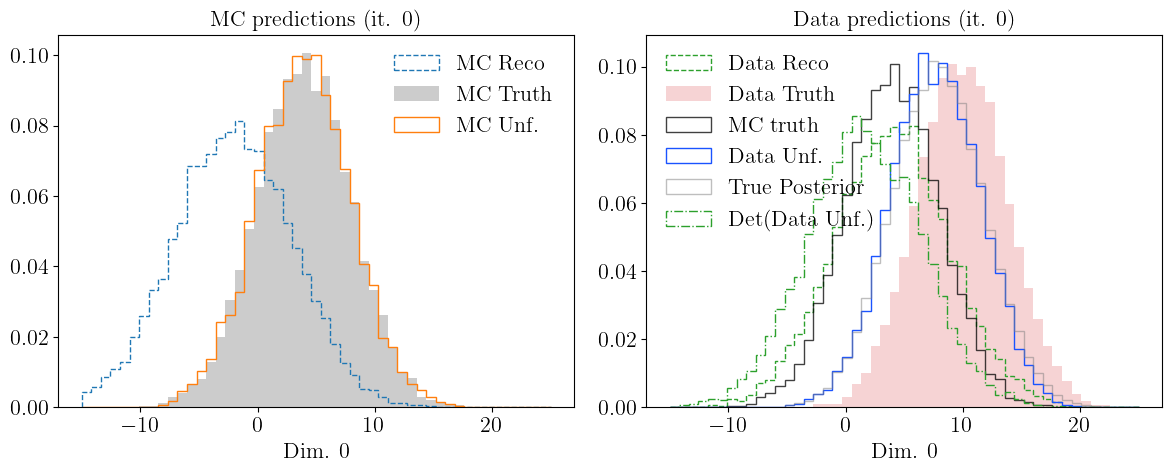

Starting Classifier training
Training classifier for 15 epochs with lr 0.0001
Finished epoch 0 with average loss 1.3864243769947486
Finished epoch 10 with average loss 1.1899632758732084
Finished classifier training. Starting Classifier predictions


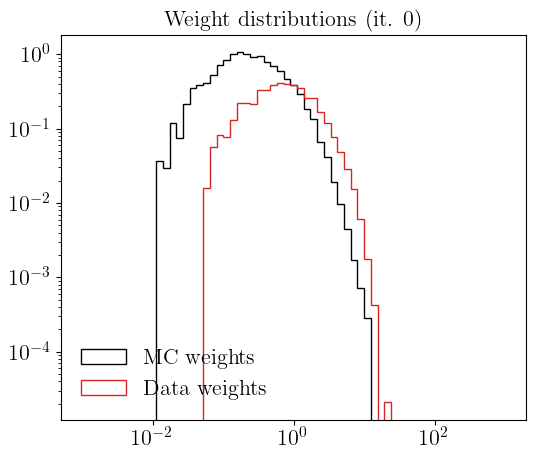

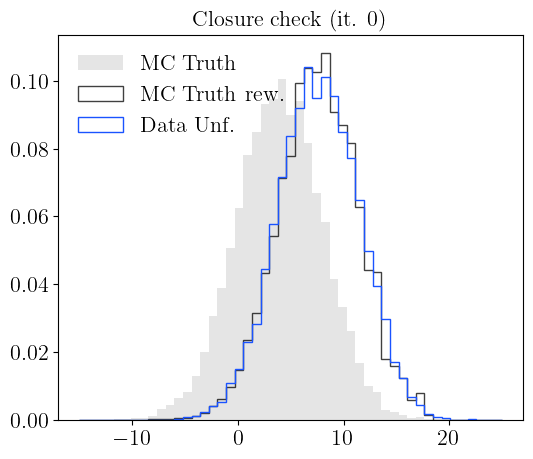

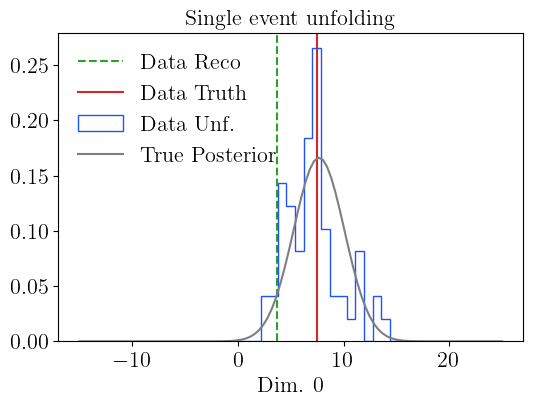


----------------------------
ITERATION 1
----------------------------
Starting CFM training for it. 1
Training CFM for 40 epochs with learning rate: 0.001
Finished epoch 0 with average loss 1.000794
Finished epoch 10 with average loss 0.983631
Finished epoch 20 with average loss 0.915253
Finished epoch 30 with average loss 0.959091
Finished CFM training. Generating samples for MC and Data sets...


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


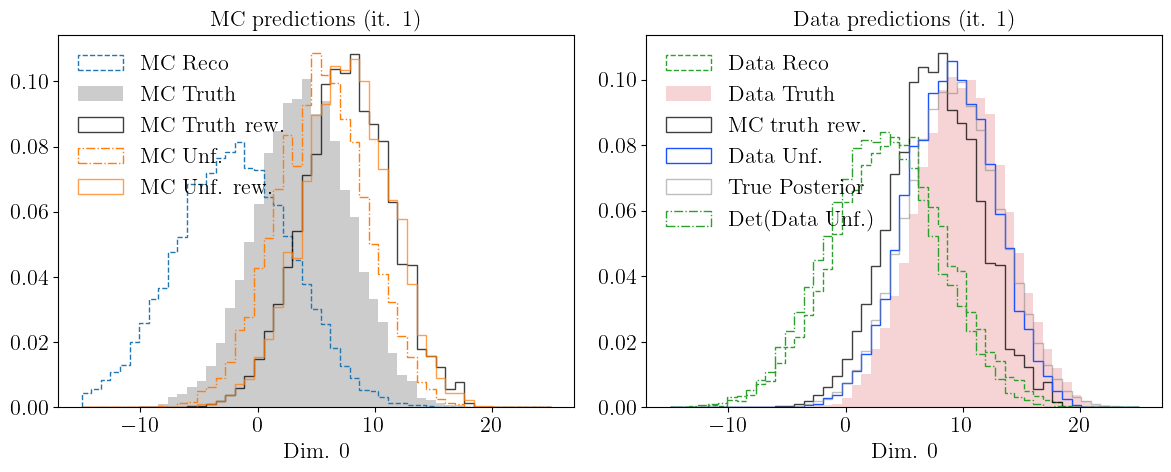

Starting Classifier training
Training classifier for 15 epochs with lr 0.0001
Finished epoch 0 with average loss 1.045280600650401
Finished epoch 10 with average loss 1.0387772434874425
Finished classifier training. Starting Classifier predictions


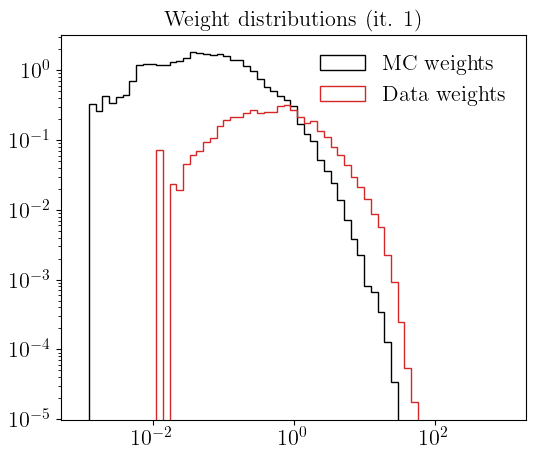

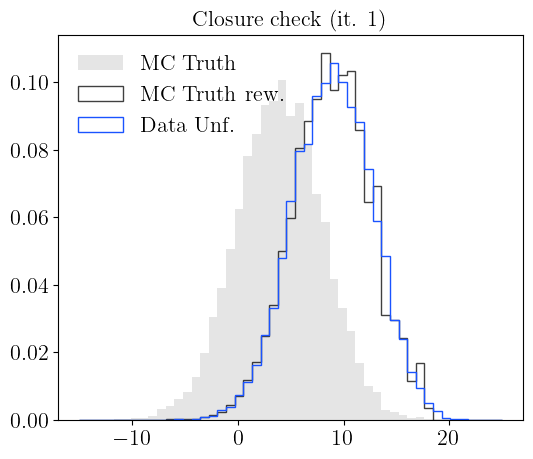

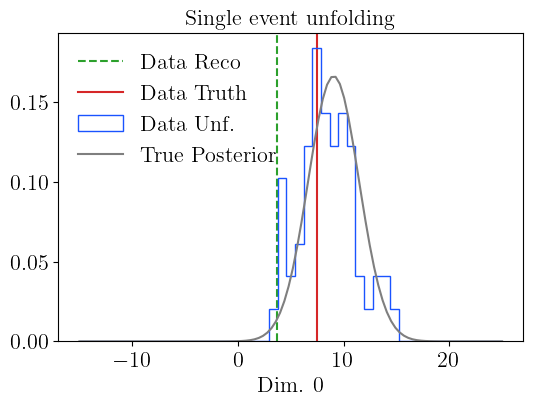


----------------------------
ITERATION 2
----------------------------
Starting CFM training for it. 2
Training CFM for 40 epochs with learning rate: 0.001
Finished epoch 0 with average loss 0.916861
Finished epoch 10 with average loss 0.927965
Finished epoch 20 with average loss 0.917340
Finished epoch 30 with average loss 0.912760
Finished CFM training. Generating samples for MC and Data sets...


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


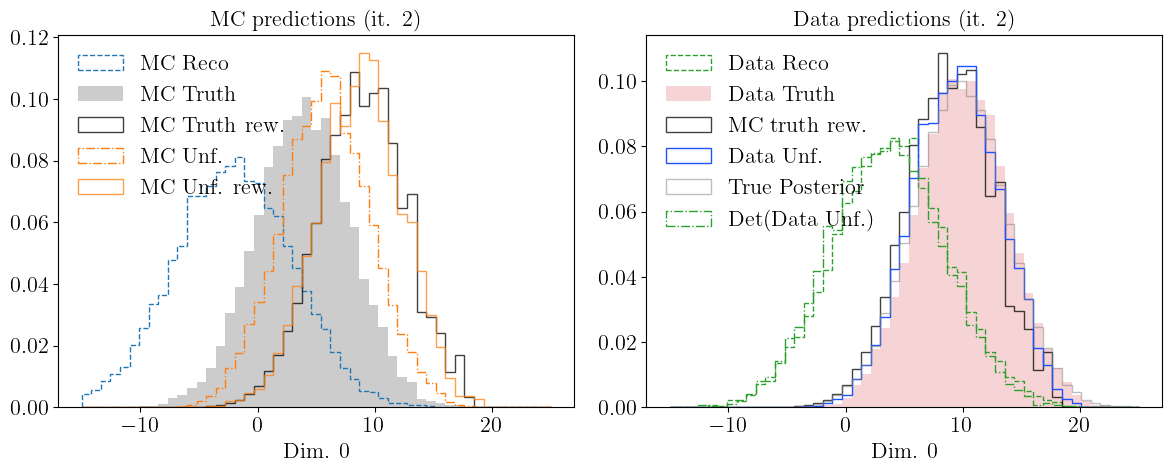

Starting Classifier training
Training classifier for 15 epochs with lr 0.0001
Finished epoch 0 with average loss 0.9799140231518806
Finished epoch 10 with average loss 0.97852598790881
Finished classifier training. Starting Classifier predictions


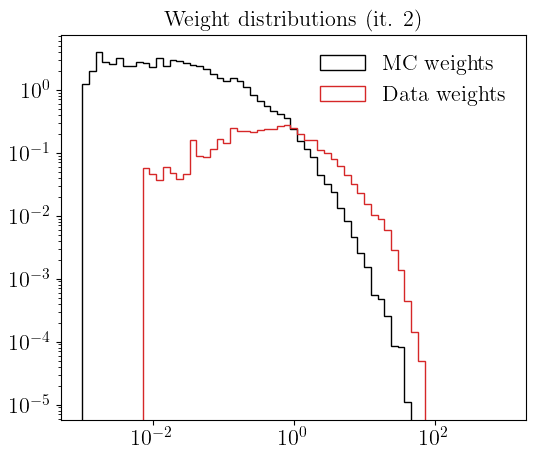

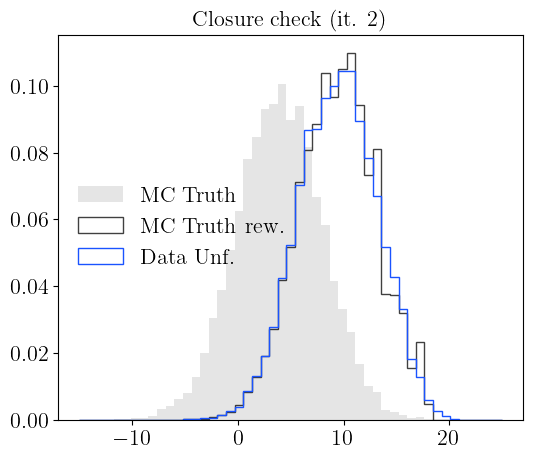

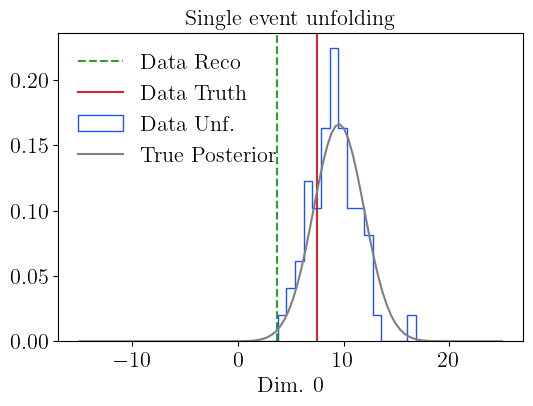


----------------------------
ITERATION 3
----------------------------
Starting CFM training for it. 3
Training CFM for 40 epochs with learning rate: 0.001
Finished epoch 0 with average loss 1.010367
Finished epoch 10 with average loss 0.956622
Finished epoch 20 with average loss 0.890135
Finished epoch 30 with average loss 0.976376
Finished CFM training. Generating samples for MC and Data sets...


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


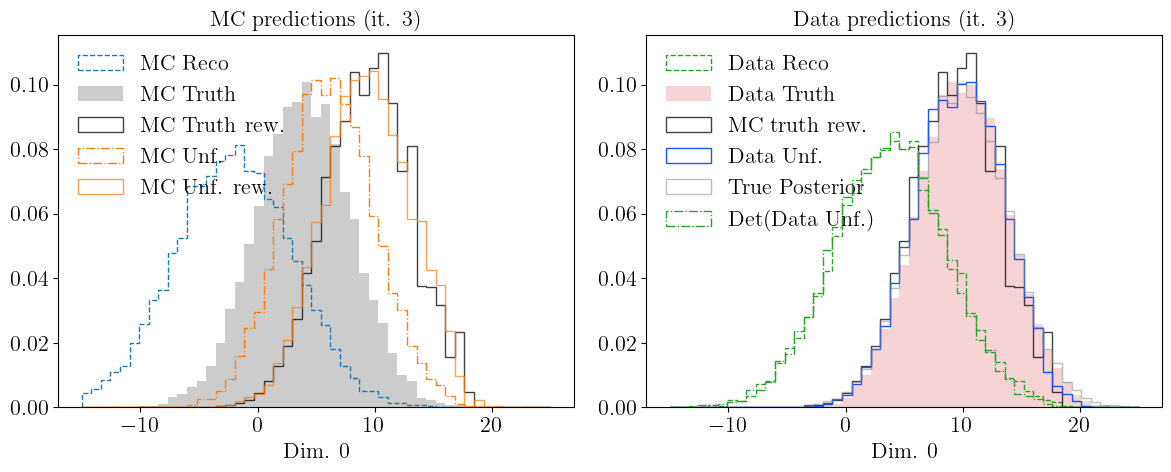

Starting Classifier training
Training classifier for 15 epochs with lr 0.0001
Finished epoch 0 with average loss 0.9543950308727313
Finished epoch 10 with average loss 0.9530656624443924
Finished classifier training. Starting Classifier predictions


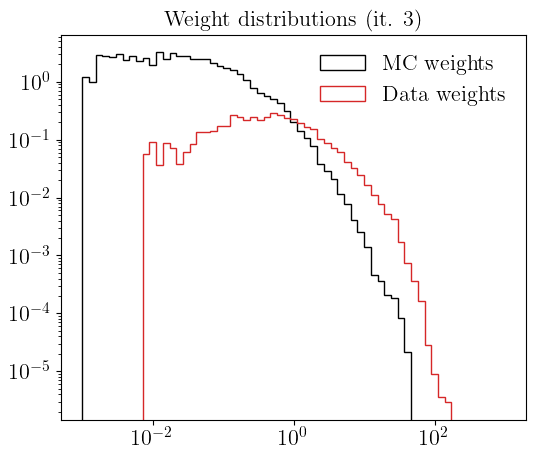

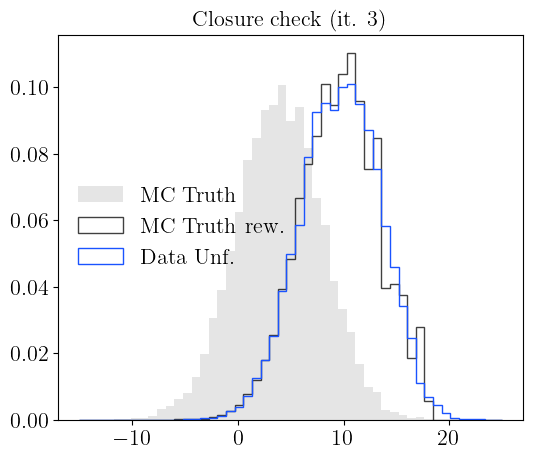

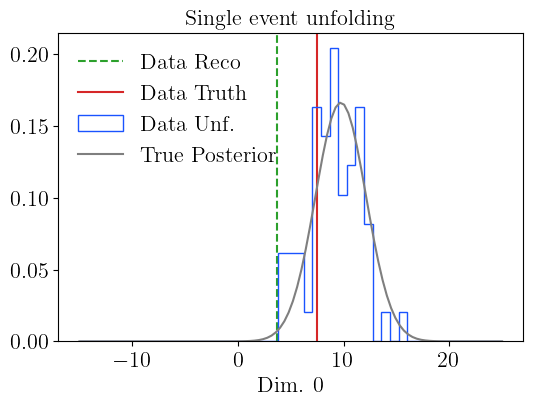

In [9]:
n_MC = 10000
n_data = 10000

# MC_truth = torch.randn(n_MC, 1) * 4
# MC_reco = (torch.randn_like(MC_truth)*3 + 1 + MC_truth)
# data_truth = torch.randn(n_data, 1) * 4 + 6
# data_reco = (torch.randn_like(data_truth)*3 + 1 + data_truth)

MC_truth_mu = 4.
MC_truth_sigma = 4.
data_truth_mu = 10.
data_truth_sigma = 3.8
mu_smear = -6.
sigma_smear = 3.
iterations = 4

MC_truth = torch.randn(n_MC, 1) * MC_truth_sigma + MC_truth_mu
MC_reco = (torch.randn_like(MC_truth)*sigma_smear + mu_smear + MC_truth)
data_truth = torch.randn(n_data, 1)*data_truth_sigma + data_truth_mu
data_reco = (torch.randn_like(data_truth)*sigma_smear + mu_smear + data_truth)

bins = [np.linspace(-15, 25, 50)]

cfm_params = {"layers_width": 64, "n_hidden_layers": 4, "n_epochs": 40, "lr": 1.e-3, "batch_size": 512}
classifier_params = {"layers_width": 32, "n_hidden_layers": 4, "n_epochs": 15, "lr": 1.e-4, "batch_size": 128}


cfm = Iterative_CFM(
    dims_truth=1, 
    dims_reco=1,
    cfm_params=cfm_params,
    classifier_params=classifier_params,
    MC_reco = MC_reco,
    MC_truth = MC_truth,
    data_reco = data_reco,
    data_truth = data_truth,
    bins=bins,
    mu_unf=MC_truth_mu,
    sigma_unf=MC_truth_sigma,
    data_truth_mu=data_truth_mu,
    mu_smear=mu_smear,
    sigma_smear=sigma_smear,
)

cfm.train(iterations = iterations, bs_sample = 8192)

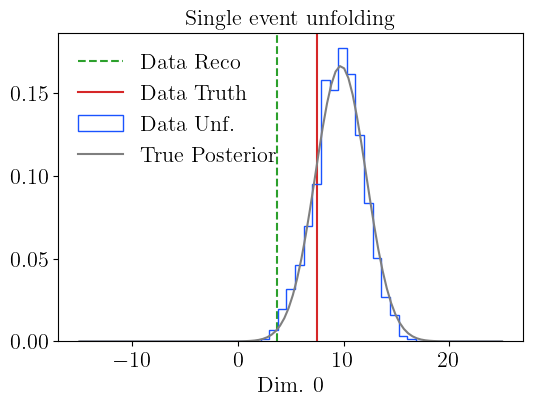

In [11]:
def plot_single_event_unfolding(event_idx, n_unfoldings = 128):
        '''
        Plots the multiple unfolding for a single event
        '''

        bins = cfm.bins[0]
        data_samples = []
        with torch.no_grad():
            for _ in range(n_unfoldings):
                unfoldings_norm = cfm.sample_cfm(cfm.data_reco[[event_idx]]).squeeze().detach()
                unfoldings = unfoldings_norm * cfm.MC_truth_std + cfm.MC_truth_mean
                data_samples.append(unfoldings)
        data_samples = np.array(data_samples)

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.axvline(cfm.data_reco[event_idx] * cfm.MC_reco_std + cfm.MC_reco_mean, color=DATA_RECO_COLOR, ls="dashed", label="Data Reco")
        ax.axvline(cfm.data_truth[event_idx] * cfm.MC_truth_std + cfm.MC_truth_mean, color=DATA_HARD_COLOR, ls="solid", label="Data Truth")
        ax.hist(data_samples, density=True, histtype="step", bins=bins, label="Data Unf.", color = DATA_UNFOLD_COLOR, ls="solid")
        mu_single = (cfm.sigma_smear ** 2 * cfm.mu_unf - cfm.sigma_unf ** 2 * (cfm.mu_smear - (cfm.data_reco[event_idx] * cfm.MC_reco_std + cfm.MC_reco_mean).numpy())) / (cfm.sigma_smear ** 2 + cfm.sigma_unf ** 2)
        
        sigma_single2 = cfm.sigma_unf ** 2 * cfm.sigma_smear ** 2 / (cfm.sigma_smear ** 2 + cfm.sigma_unf ** 2)
        mu_single, sigma_single2 = cfm.get_true_posterior_single(event_idx)

        x = np.linspace(bins.min(), bins.max(), 100)
        ax.plot(x, 1 / np.sqrt(2 * np.pi * sigma_single2) * np.exp(-0.5 * (x - mu_single) ** 2 / sigma_single2), color="C7", ls="solid", label="True Posterior")
        ax.legend(frameon=False)
        ax.set_title(f"Single event unfolding")
        ax.set_xlabel(f"Dim. 0")
        plt.show()
plot_single_event_unfolding(3, 6000)

# Second example: Pythia and Herwig jet substructure observables

In this case we move on to a more physics-inspired example, where we use Pythia (representing our MC) and Herwig, representing our Data.

In [39]:
def get_observables(dataset):

    feature_names = ['widths', 'mults', 'tau2s']
    gen_features = [dataset['gen_jets'][:, 3]]
    sim_features = [dataset['sim_jets'][:, 3]]

    for feature in feature_names:
        gen_features.append(dataset['gen_' + feature])
        sim_features.append(dataset['sim_' + feature])

    gen_features = np.stack(gen_features, -1)
    sim_features = np.stack(sim_features, -1)
    # # ln rho
    # gen_features[:, 3] = 2 * np.ma.log(
    #     np.ma.divide(gen_features[:, 3], dataset['gen_jets'][:, 0]).filled(0)).filled(0)
    # sim_features[:, 3] = 2 * np.ma.log(
    #     np.ma.divide(sim_features[:, 3], dataset['sim_jets'][:, 0]).filled(0)).filled(0)
    # tau2
    gen_features[:, 3] = gen_features[:, 3] / (10 ** -50 + gen_features[:, 1])
    sim_features[:, 3] = sim_features[:, 3] / (10 ** -50 + sim_features[:, 1])
    return gen_features, sim_features


----------------------------
ITERATION 0
----------------------------
Starting CFM training for it. 0
MC_reco shape torch.Size([50000, 4])
Training CFM for 60 epochs with learning rate: 0.001
Finished epoch 0 with average loss 1.455276
Finished epoch 10 with average loss 0.748742
Finished epoch 20 with average loss 0.728762
Finished epoch 30 with average loss 0.710359
Finished epoch 40 with average loss 0.705847
Finished epoch 50 with average loss 0.700365
MC_reco shape torch.Size([50000, 4])
----------------------------
Finished CFM training. Generating samples for MC and Data sets
----------------------------


100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])


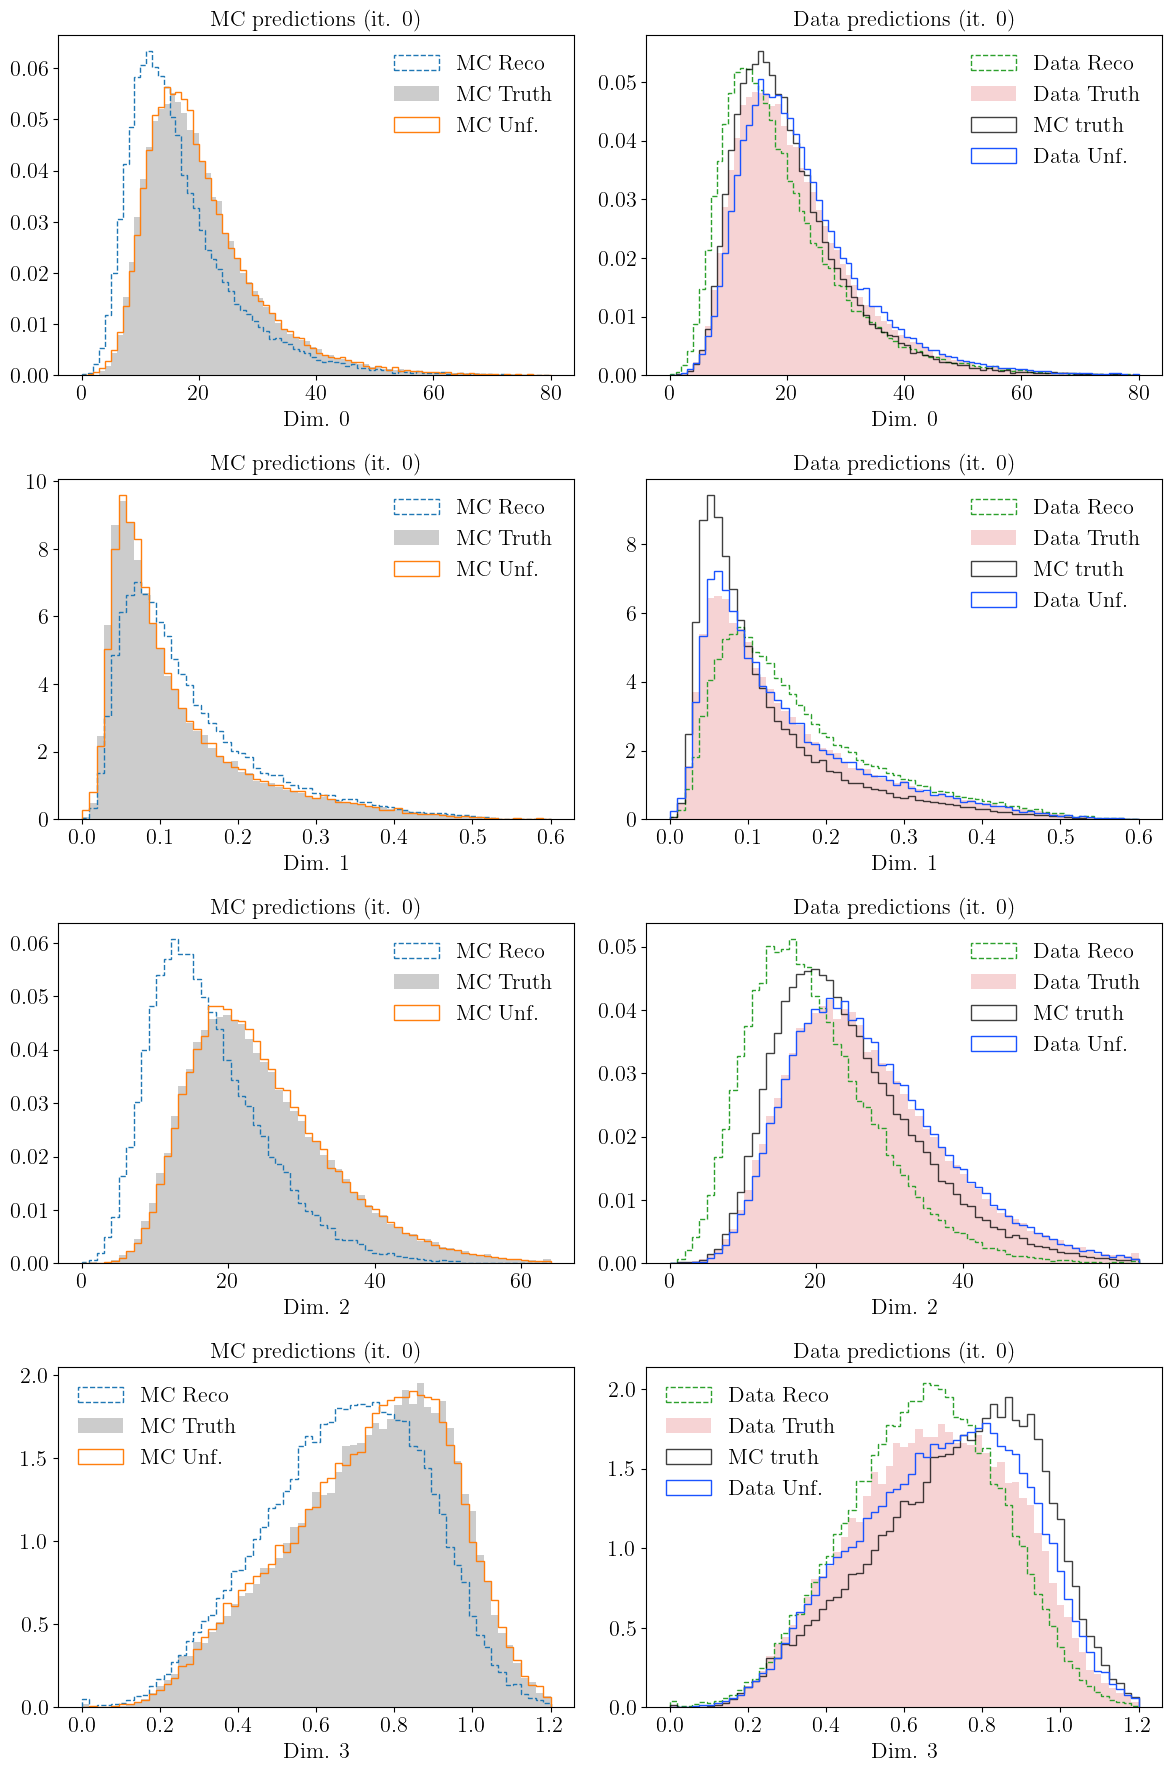

----------------------------
Finished CFM training. Starting Classifier training
----------------------------
Training classifier for 20 epochs with lr 0.0001
Finished epoch 0 with average loss 1.3789220209926596
Finished epoch 10 with average loss 1.362548065002617
----------------------------
Finished classifier training. Starting Classifier predictions
----------------------------


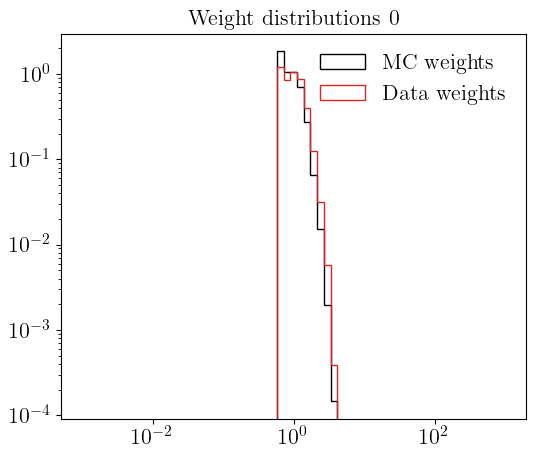




----------------------------
ITERATION 1
----------------------------
Starting CFM training for it. 1
MC_reco shape torch.Size([50000, 4])
Training CFM for 60 epochs with learning rate: 0.001
Finished epoch 0 with average loss 0.735056
Finished epoch 10 with average loss 0.721474
Finished epoch 20 with average loss 0.720346
Finished epoch 30 with average loss 0.709429
Finished epoch 40 with average loss 0.707047
Finished epoch 50 with average loss 0.705669
MC_reco shape torch.Size([50000, 4])
----------------------------
Finished CFM training. Generating samples for MC and Data sets
----------------------------


100%|██████████| 7/7 [00:33<00:00,  4.76s/it]


(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])


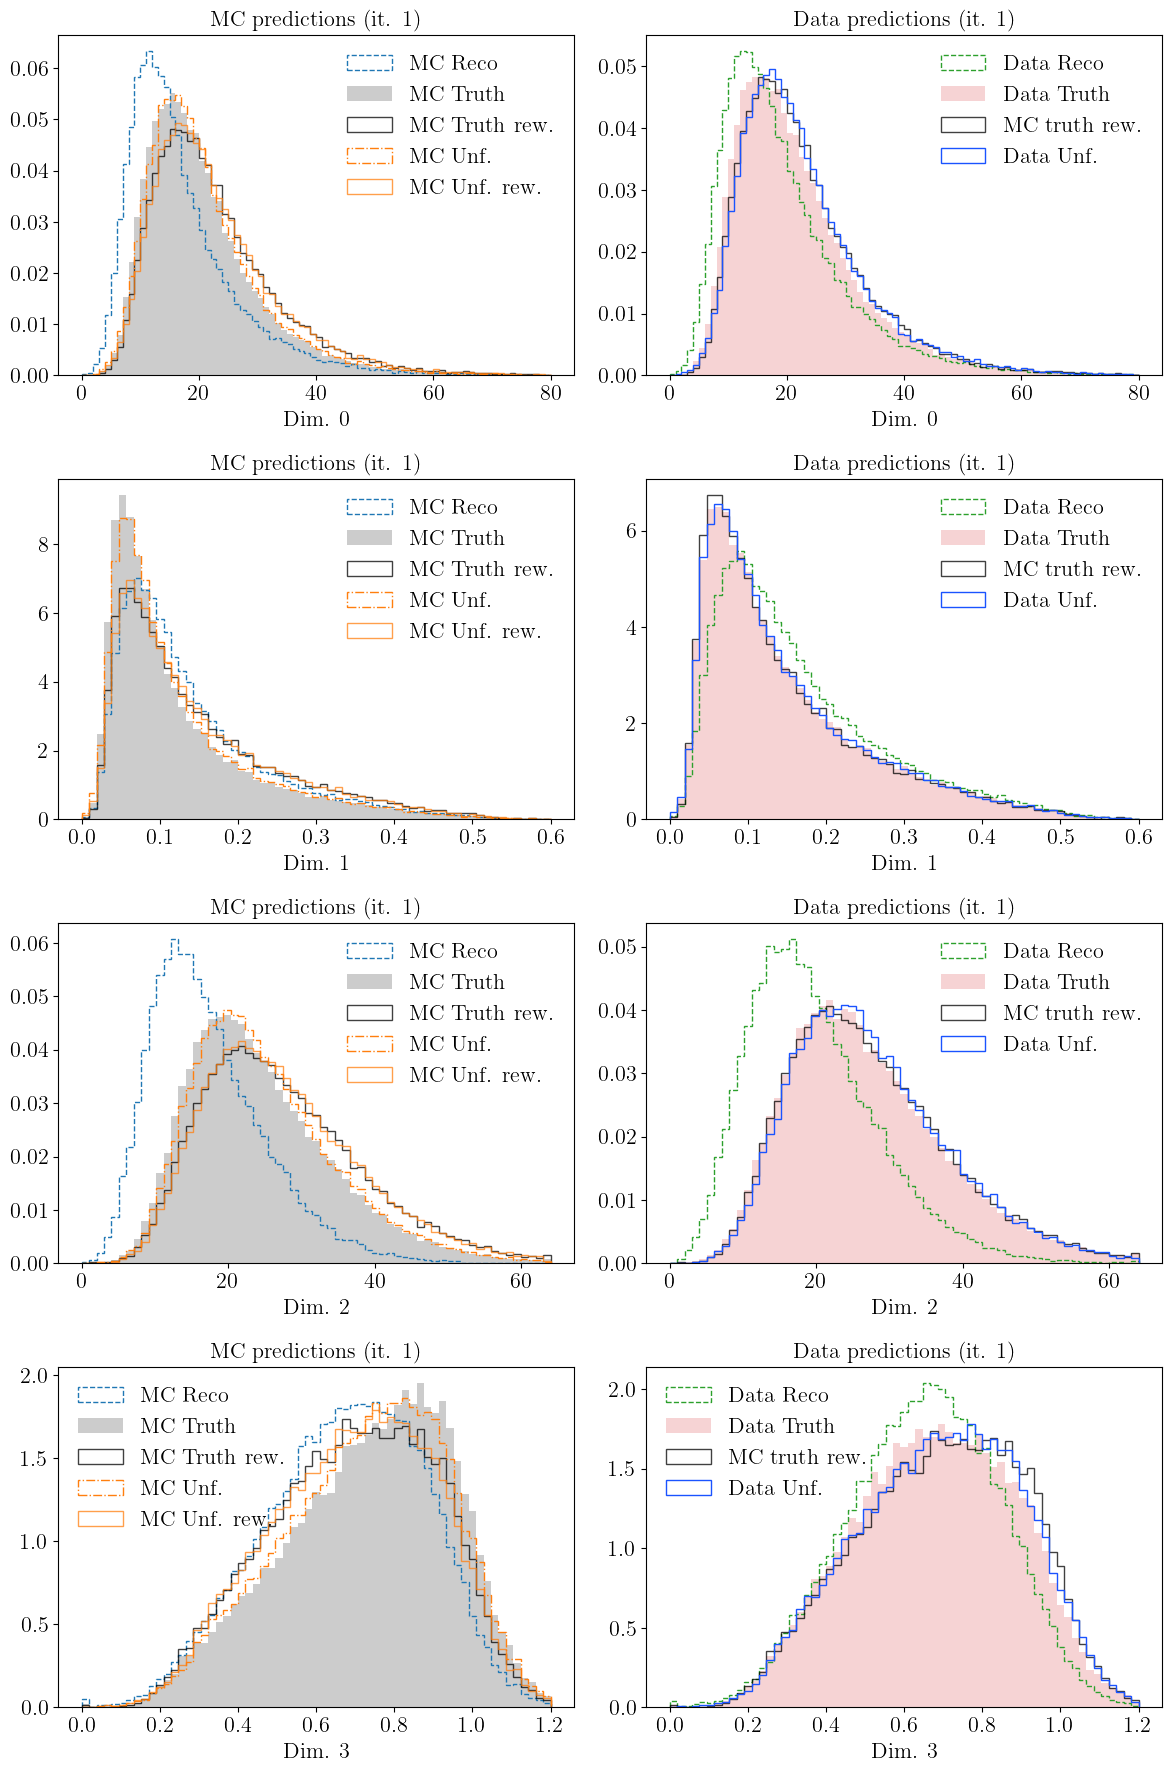

----------------------------
Finished CFM training. Starting Classifier training
----------------------------
Training classifier for 20 epochs with lr 0.0001
Finished epoch 0 with average loss 1.35459886030163
Finished epoch 10 with average loss 1.3535951790602312
----------------------------
Finished classifier training. Starting Classifier predictions
----------------------------


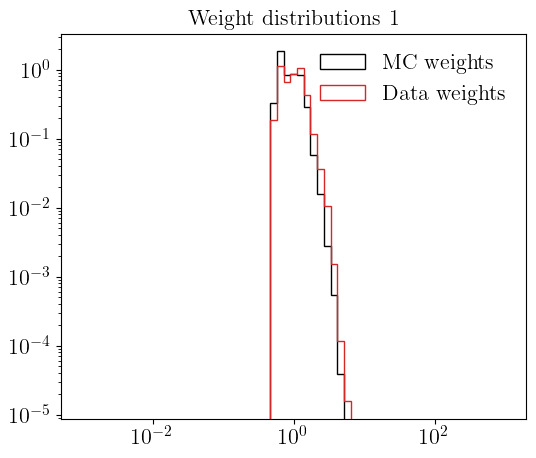




----------------------------
ITERATION 2
----------------------------
Starting CFM training for it. 2
MC_reco shape torch.Size([50000, 4])
Training CFM for 60 epochs with learning rate: 0.001
Finished epoch 0 with average loss 0.713175
Finished epoch 10 with average loss 0.715022
Finished epoch 20 with average loss 0.706205
Finished epoch 30 with average loss 0.704476
Finished epoch 40 with average loss 0.703075
Finished epoch 50 with average loss 0.696014
MC_reco shape torch.Size([50000, 4])
----------------------------
Finished CFM training. Generating samples for MC and Data sets
----------------------------


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])


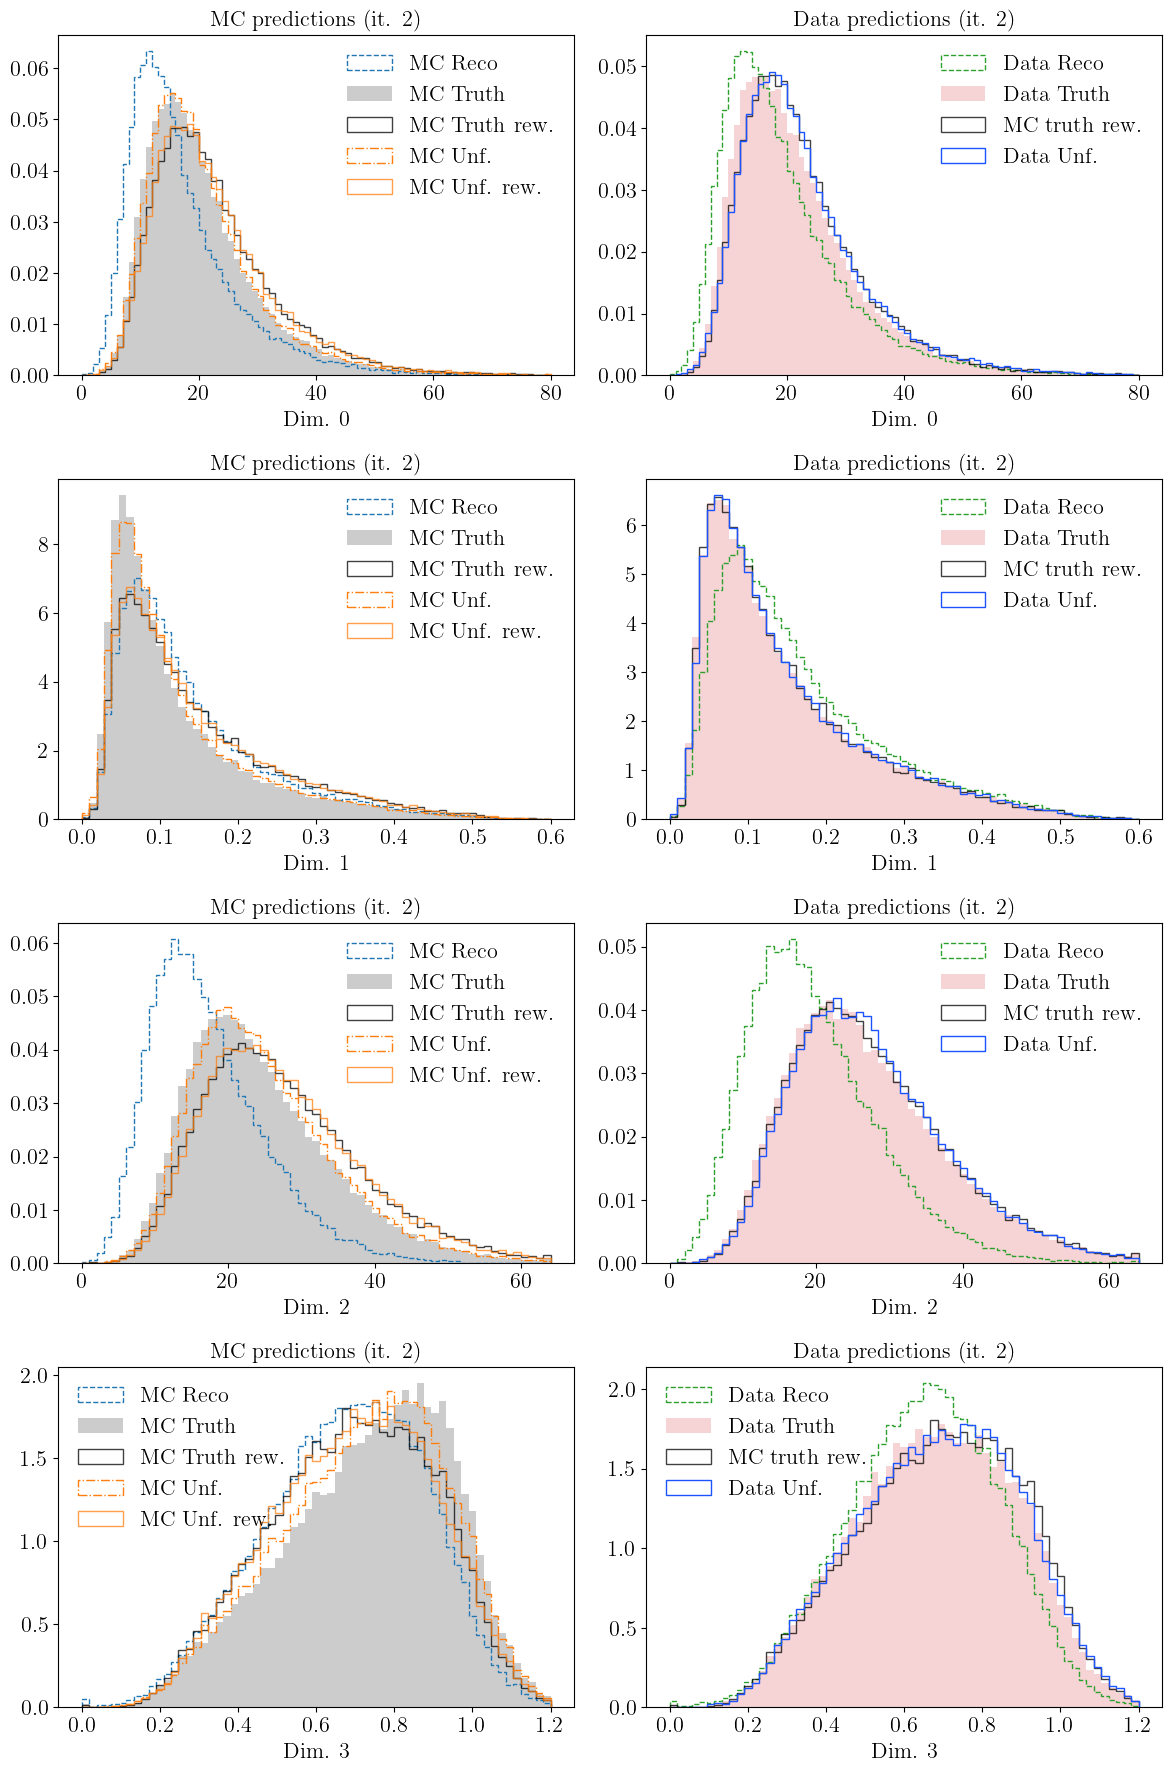

----------------------------
Finished CFM training. Starting Classifier training
----------------------------
Training classifier for 20 epochs with lr 0.0001
Finished epoch 0 with average loss 1.3499828756922652
Finished epoch 10 with average loss 1.3484937906875025
----------------------------
Finished classifier training. Starting Classifier predictions
----------------------------


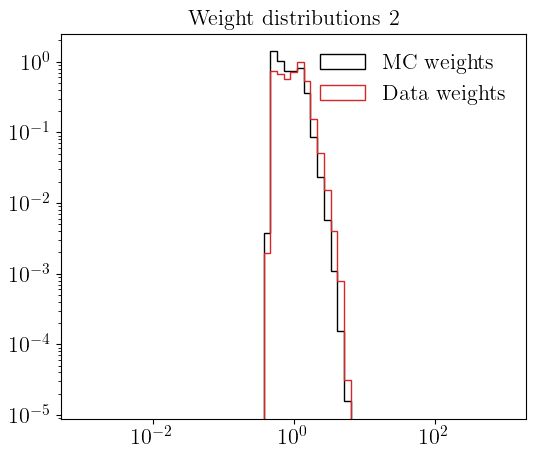




----------------------------
ITERATION 3
----------------------------
Starting CFM training for it. 3
MC_reco shape torch.Size([50000, 4])
Training CFM for 60 epochs with learning rate: 0.001
Finished epoch 0 with average loss 0.730002
Finished epoch 10 with average loss 0.728230
Finished epoch 20 with average loss 0.729409
Finished epoch 30 with average loss 0.721595
Finished epoch 40 with average loss 0.712631
Finished epoch 50 with average loss 0.713134
MC_reco shape torch.Size([50000, 4])
----------------------------
Finished CFM training. Generating samples for MC and Data sets
----------------------------


100%|██████████| 7/7 [03:15<00:00, 27.91s/it]


(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])
(50000,) torch.Size([50000, 1])


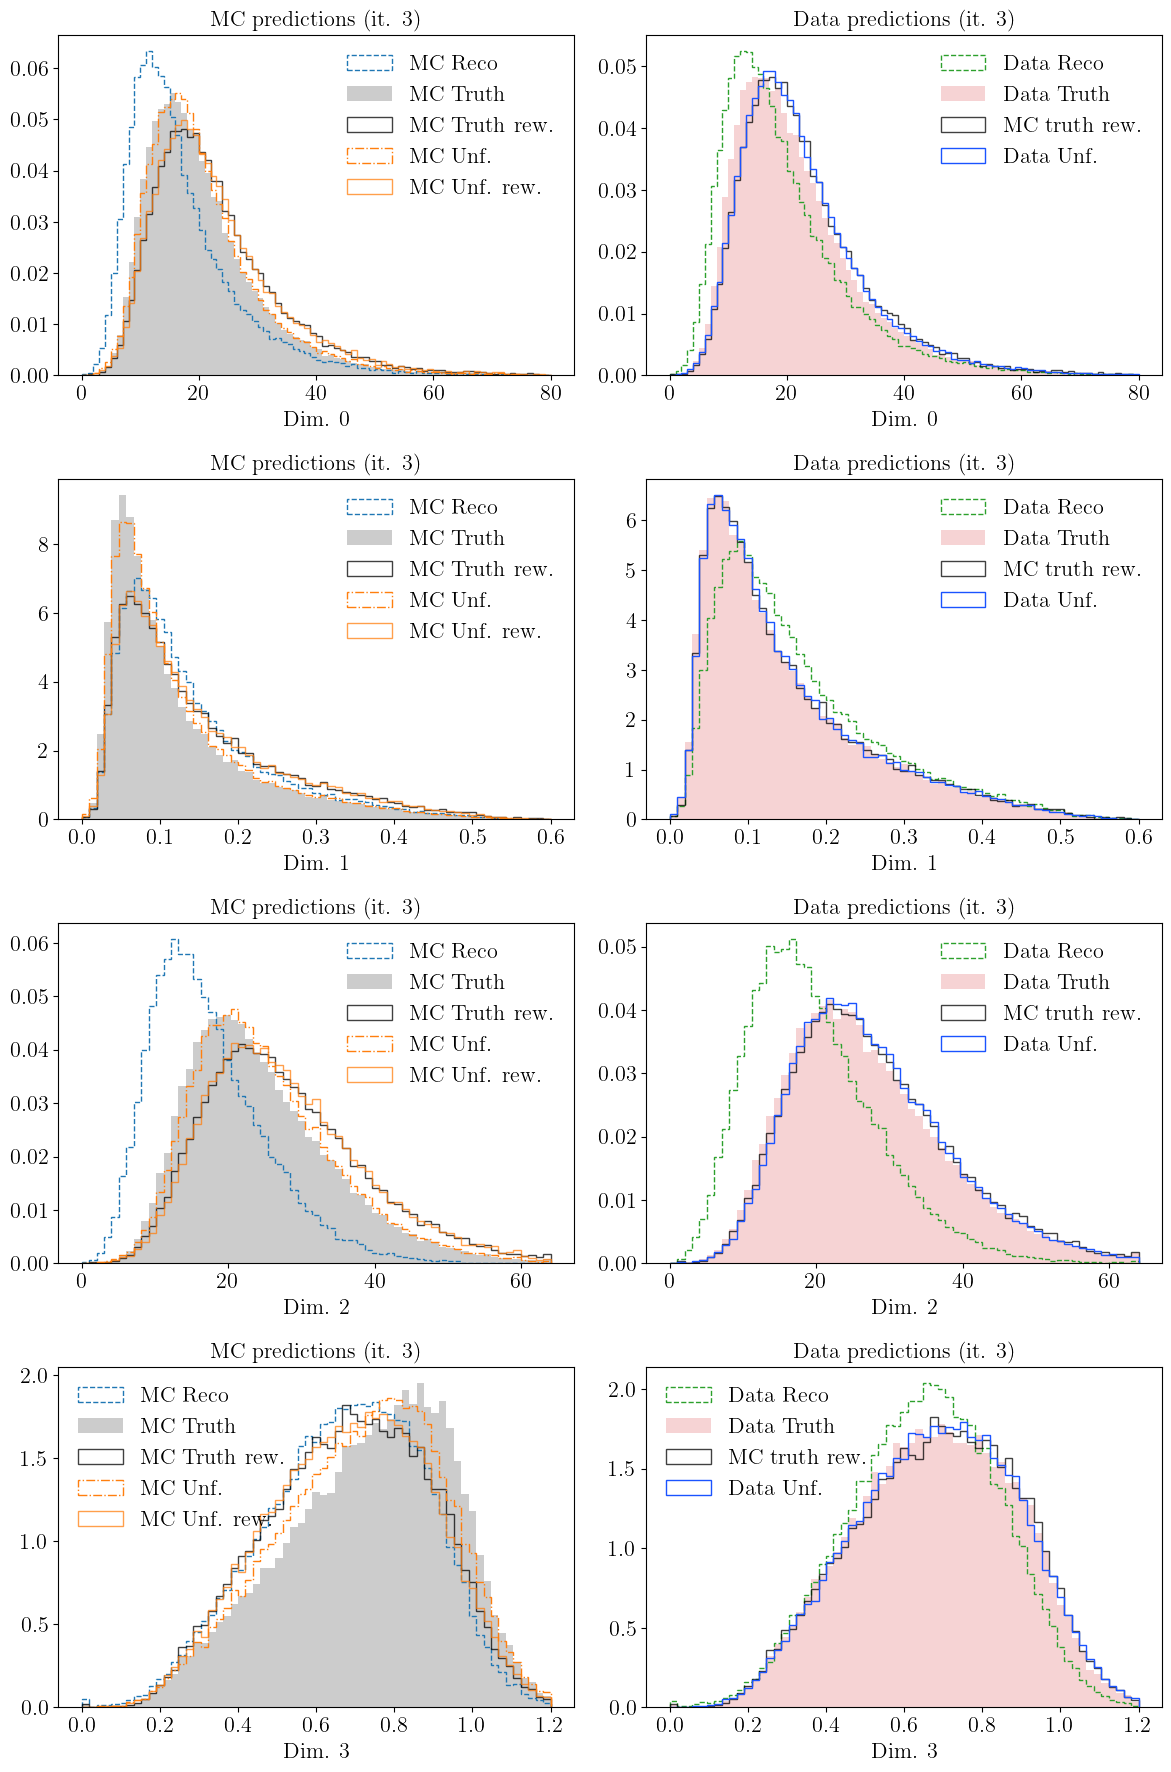

----------------------------
Finished CFM training. Starting Classifier training
----------------------------
Training classifier for 20 epochs with lr 0.0001
Finished epoch 0 with average loss 1.3452757374404947
Finished epoch 10 with average loss 1.344469148179759
----------------------------
Finished classifier training. Starting Classifier predictions
----------------------------


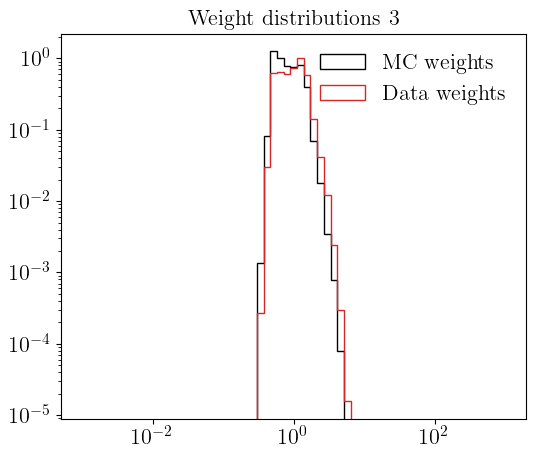

In [43]:
pythia = ef.zjets_delphes.load('Pythia26', num_data=50000, pad =True, cache_dir="./") # our sythetic sim
herwig = ef.zjets_delphes.load("Herwig", num_data=50000, pad=True, cache_dir='./')

# # sim
MC_truth, MC_reco = get_observables(pythia)
# # 'data'
data_truth, data_reco = get_observables(herwig)
bins = [np.linspace(0, 80,  81),    # jet mass
        np.linspace(0, .6, 64),     # jet  width
        np.linspace(0.0, 64, 64),   # jet N
        # np.linspace(-14, -2,  64),  # jet groomed mass
        # np.linspace(0, 0.5, 51),
        np.linspace(0, 1.2, 64)     # subjettiness ratio
        ]     # multiplicity

# From Fernando's code
# MC_reco = np.column_stack((pythia['sim_jets'], pythia['sim_mults']))
# MC_truth = np.column_stack((pythia['gen_jets'], pythia['gen_mults']))
# data_reco = np.column_stack((herwig['sim_jets'], herwig['sim_mults']))
# data_truth = np.column_stack((herwig['gen_jets'], herwig['gen_mults']))

# bins = [ #simple plotting bins
# np.linspace(0, 80,  81),    #jet mass
# np.linspace(0, 800,  81),   #jet width
# np.linspace(-4, 4, 81),     #jet y
# np.linspace(0.0, 6.2, 63),  #jet phi
# np.linspace(0, 80, 81)]     # multiplicity

MC_reco = torch.tensor(MC_reco, dtype=torch.float32)
MC_truth = torch.tensor(MC_truth, dtype=torch.float32)
data_reco = torch.tensor(data_reco, dtype=torch.float32)
data_truth = torch.tensor(data_truth, dtype=torch.float32)

cfm_params = {"layers_width": 64, "n_hidden_layers": 4, "n_epochs": 60, "lr": 1.e-3, "batch_size": 512}
classifier_params = {"layers_width": 32, "n_hidden_layers": 4, "n_epochs": 20, "lr": 1.e-4, "batch_size": 128}
cfm = Iterative_CFM(
    dims_truth=len(bins), 
    dims_reco=len(bins),
    cfm_params=cfm_params,
    classifier_params=classifier_params,
    MC_reco = MC_reco,
    MC_truth = MC_truth,
    data_reco = data_reco,
    data_truth = data_truth,
    bins=bins,
)

cfm.train(iterations = 4, bs_sample = 8192)